### Calculate the road distances between each PAL field - candidate location 

In [4]:
import osmnx as ox
import geopandas as gpd
import networkx as nx
import pandas as pd
import csv
import os

In [5]:
# define paths
data_path = 'data'
output_path = 'output'

# set parent folder as working directory
os.chdir('..')
os.getcwd()

'c:\\Users\\isaldiviagonzatti\\Downloads\\gitFiles\\MScThesisCode\\FLP'

### Example with Pital (CR)

In [6]:
xlon = -84.278967
ylat = 10.476319
point = ylat, xlon # center of PA field near Pital

examG = ox.graph_from_point(point, network_type='all_private', dist=1000)

# impute missing edge speeds and add travel times
#G = ox.add_edge_speeds(G)
#G = ox.add_edge_travel_times(G)

In [7]:
# calculate route minimizing some weight (distance in this case)
orig, dest = list(examG)[4], list(examG)[-1]
route = nx.shortest_path_length(examG, orig, dest, weight='length')

In [8]:
print('Lenght of the route between the two points in meters is ' + str(round(route)))

Lenght of the route between the two points in meters is 893


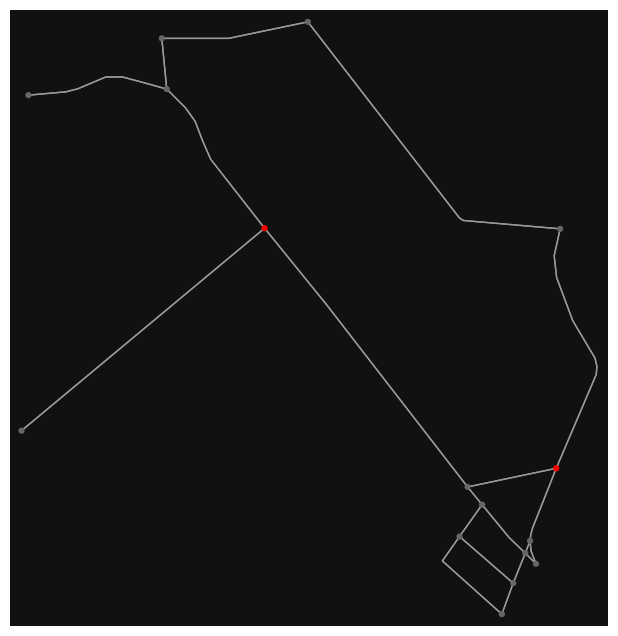

In [9]:
# plot between the two points
unique_edges = list(examG)[4], list(examG)[-1]
ec = ['r' if e in unique_edges else '#666666' for e in examG.nodes]
#fig, ax = ox.plot_graph(G, edge_color=ec, edge_linewidth=1, node_size=0, show=False)
fig, ax = ox.plot_graph(examG, node_color=ec, edge_linewidth=1, node_size=20, show=False)

In [32]:
# load PAL field nodes
with open(os.path.join(output_path, "nearestNodePAL.csv"), newline='') as f:
    reader = csv.reader(f)
    palFields = list(reader)

origs = list(set(palFields[0]))

In [34]:
for i in range(0, len(origs)):
    origs[i] = int(origs[i])

In [35]:
# load facility candidates nodes
with open(os.path.join(output_path, "canNetwork.csv"), newline='') as f:
    reader = csv.reader(f)
    candidates = list(reader)

dests = list(set(candidates[0]))

In [36]:
for i in range(0, len(dests)):
    dests[i] = int(dests[i])

In [37]:
# create dataframes for origs and dests
origs = pd.DataFrame(origs, columns=['origs'])
dests = pd.DataFrame(dests, columns=['dests'])

In [38]:
# Create a dataframe with all combinations of origin-candidates
matrix = origs.merge(dests, how='cross')
print('We have ' + str(len(matrix)) + ' paths')

We have 570174 paths


In [39]:
matrix.dtypes

origs    int64
dests    int64
dtype: object

In [40]:
sampl_df = matrix.head(500).copy()
sampl_df

,origs,dests
0,9321067326,3934113197
1,9321067326,990276754
2,9321067326,2390780609
3,9321067326,1049251210
4,9321067326,5326294638
...,...,...
495,3940030173,312587257
496,3940030173,5605082613
497,3940030173,332722599
498,3940030173,3874140238


In [41]:
%%time
# create network from OSMnx (loading locally saved network produces errors)
G = ox.graph.graph_from_bbox(11.2, 10.00, -83, -85.2, network_type = 'drive_service')
Gs = ox.utils_graph.get_largest_component(G, strongly=True) #for strongly connected network

CPU times: total: 1min 7s
Wall time: 1min 10s


To get shortest path, we can use networkx or OSMnx. For the entire matrix, this took more than 24 hours (not shown here). Perhaps there is a faster way, and perhaps using euclidean distances is sufficiently good (and it is fast). 

In [42]:
%%time
# try to get shortest path with networkx
def short_path_length(row):
    return nx.shortest_path_length(Gs, row['origs'], row['dests'], weight='length')
sampl_df['path_length'] = sampl_df.apply(short_path_length, axis=1)

CPU times: total: 1min 16s
Wall time: 1min 17s


In [45]:
%%time
# try with OSMnx, it returns all the edges connecting the orig-dest
sampl_df['path_OX'] = ox.shortest_path(Gs, sampl_df['origs'], sampl_df['dests'], weight='length')

CPU times: total: 56.7 s
Wall time: 57.3 s


In [46]:
# distances in meters
sampl_df

,origs,dests,path_length,path_lengthOX,path_OX
0,9321067326,3934113197,104878.939,"[9321067326, 9854494186, 9321065684, 932106567...","[9321067326, 9854494186, 9321065684, 932106567..."
1,9321067326,990276754,134144.451,"[9321067326, 9854494186, 9321065684, 932106567...","[9321067326, 9854494186, 9321065684, 932106567..."
2,9321067326,2390780609,52229.198,"[9321067326, 9854494186, 9321065684, 932106567...","[9321067326, 9854494186, 9321065684, 932106567..."
3,9321067326,1049251210,155783.352,"[9321067326, 9854494186, 9321065684, 932106567...","[9321067326, 9854494186, 9321065684, 932106567..."
4,9321067326,5326294638,108997.806,"[9321067326, 9853696637, 9853696643, 985369664...","[9321067326, 9853696637, 9853696643, 985369664..."
...,...,...,...,...,...
495,3940030173,312587257,173658.173,"[3940030173, 3279917893, 185488060, 3066065025...","[3940030173, 3279917893, 185488060, 3066065025..."
496,3940030173,5605082613,202736.143,"[3940030173, 3279917893, 185488060, 3066065025...","[3940030173, 3279917893, 185488060, 3066065025..."
497,3940030173,332722599,156649.451,"[3940030173, 3279917893, 185488060, 3066065025...","[3940030173, 3279917893, 185488060, 3066065025..."
498,3940030173,3874140238,40593.641,"[3940030173, 3279917893, 185488060, 3066065025...","[3940030173, 3279917893, 185488060, 3066065025..."
